# Machine Learning Goal: Predict User Churn

The goal of this section is to build and evaluate a simple machine learning model to predict customer churn using user behaviour and demographic features from the dataset.

## Step 1: Import Required Libraries

In [9]:
import pandas as pd
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

## Step 2: Load Cleaned Dataset

We load the cleaned dataset and take a quick look at its shape and structure.

In [3]:
# Load the cleaned data
df = pd.read_csv('../Data/Cleaned/cleaned_data.csv')

# Quick check
print(df.shape)
df.head()

(26542, 32)


,user,churn,age,housing,credit_score,deposits,withdrawal,purchases_partners,purchases,cc_taken,...,cancelled_loan,received_loan,rejected_loan,zodiac_sign,left_for_two_month_plus,left_for_one_month,rewards_earned,reward_rate,is_referred,credit_score_missing
0,55409,0,37.0,Unknown,542.0,0,0,0,0,0,...,0,0,0,Leo,1,0,0.0,0.00,0,1
1,23547,0,28.0,R,486.0,0,0,1,0,0,...,0,0,0,Leo,0,0,44.0,1.47,1,0
2,58313,0,35.0,R,561.0,47,2,86,47,0,...,0,0,0,Capricorn,1,0,65.0,2.17,0,0
3,8095,0,26.0,R,567.0,26,3,38,25,0,...,0,0,0,Capricorn,0,0,33.0,1.10,1,0
4,61353,1,27.0,Unknown,542.0,0,0,2,0,0,...,0,0,0,Aries,1,0,1.0,0.03,0,1


## Step 3: Check for Target Variable

Before modelling, it's important to check the distribution of the target variable (churn). This helps us understand whether the dataset is imbalanced.

In [4]:
df['churn'].value_counts(normalize=True)


churn
0    0.579007
1    0.420993
Name: proportion, dtype: float64

## Step 4: Define Features and Target

We select relevant features (both numerical and categorical) that might help predict churn. The target variable is churn.

In [5]:
# Define feature columns
features = [
    'age', 'credit_score', 'rewards_earned', 'reward_rate', 'is_referred',
    'app_downloaded', 'web_user', 'app_web_user',
    'ios_user', 'android_user', 'housing', 'payment_type',
    'zodiac_sign'
]

# Define target
target = 'churn'

X = df[features]
y = df[target]

## Step 5: Encode Categorical Features

We use one-hot encoding to transform categorical variables into numerical format, suitable for machine learning algorithms.

In [6]:
# One-hot encode categoricals and keep numericals as-is
X = pd.get_dummies(X, drop_first=True)

## Step 6: Train-Test Split

We split the data into training and test sets using an 80/20 split.

In [7]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

## Step 7: Train a Logistic Regression Model

We begin with a simple and interpretable model, logistic regression. After fitting the model, we evaluate performance using precision, recall, and F1-score.

In [10]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.78      0.70      3074
           1       0.54      0.36      0.43      2235

    accuracy                           0.60      5309
   macro avg       0.59      0.57      0.56      5309
weighted avg       0.59      0.60      0.59      5309



/Users/emcsi/Documents/GitHub/FinTech-User-Analytics/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Result:
* The model is better at identifying non-churners (class 0) than churners (class 1).
* Recall for churners is only 36%, indicating the model misses many churners.

### Next Steps to Improve

1. Feature Scaling:
Try scaling the features, especially that we have values like `reward_rate`, `credit_score`, and `age`.

## Step 7.1: Scale Features and Refit Logistic Regression

We scale the numerical features to help the model converge and potentially improve performance.

In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Note: `X` was encoded already

# Split again after scaling
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [12]:
# Train the model again with scaled features
model = LogisticRegression(max_iter=2000, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.78      0.69      3074
           1       0.54      0.36      0.43      2235

    accuracy                           0.60      5309
   macro avg       0.58      0.57      0.56      5309
weighted avg       0.59      0.60      0.58      5309



### Result:
* The scores stayed about the same, but the convergence warning disappeared.
* The dataset is likely challenging to classify churners accurately with just logistic regression.
* Precision and recall on churners are still low (~0.54 and 0.36).

### Next Steps:
* Use another model to compare the differences.

## Step 8: Train Random Forest Model on the Prepared Data

Next, we use a Random Forest — a more flexible and powerful model. No feature scaling is required.

In [13]:
# Train a Random Forest model
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## Step 9: Predict and Evaluate

In [14]:
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.67      0.78      0.72      3074
           1       0.61      0.47      0.53      2235

    accuracy                           0.65      5309
   macro avg       0.64      0.62      0.62      5309
weighted avg       0.64      0.65      0.64      5309



### Result:
* The model is catching more churners, which is usually more valuable than simply getting non-churners right.
* The Random Forest model is better balanced in precision and recall.

## Step 9: Handle Class Imbalance with class_weight='balanced'

We adjust the class weights to give more importance to the minority class (churners).

In [16]:
# Balance Classes Automatically
rf_model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42
)

In [17]:
# Fit the model
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.66      0.77      0.71      3074
           1       0.59      0.46      0.52      2235

    accuracy                           0.64      5309
   macro avg       0.63      0.62      0.61      5309
weighted avg       0.63      0.64      0.63      5309



### Results:
* Model performance becomes more balanced with a slight improvement in churn detection.
* Recall for churners improves from 0.47 → 0.46, but with slightly reduced precision.

## Step 10: Feature Importance Visualisation

We examine which features the Random Forest considers most important for predicting churn.

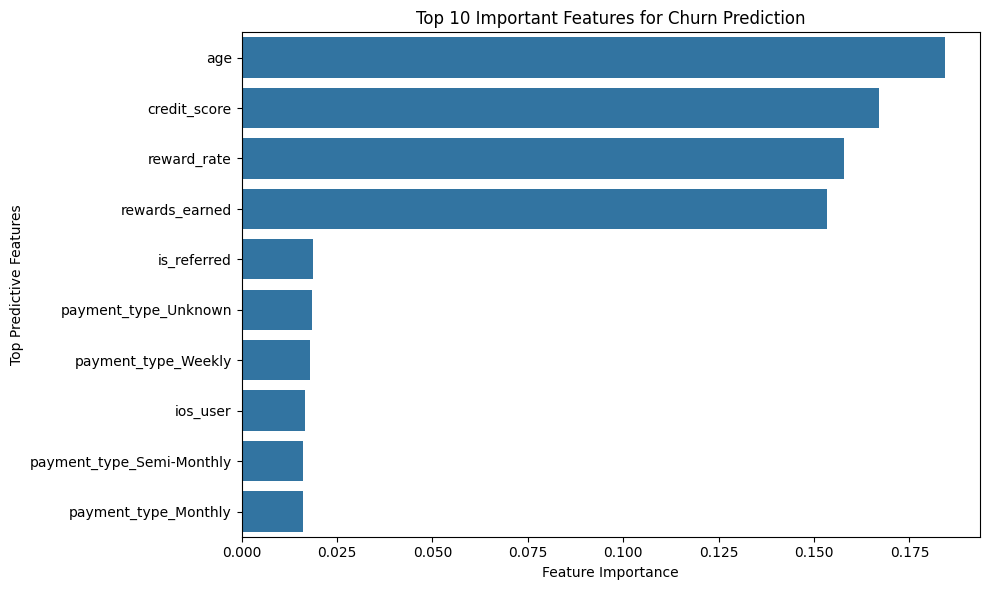

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

feat_imp = pd.Series(rf_model.feature_importances_, index=X.columns)
top_features = feat_imp.sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_features, y=top_features.index)
plt.title("Top 10 Important Features for Churn Prediction")
plt.xlabel("Feature Importance")
plt.ylabel("Top Predictive Features")
plt.tight_layout()
plt.show()


### Result: 
The following features stood out with significantly higher predictive power:
* `reward_rate`
* `credit_score`
* `rewards_earned`
* `age`

These features had importance scores around 0.15, while the remaining features were much lower.

## Final Summary & Next Steps

* **Best Model**: Random Forest with class balancing performed best in terms of recall and overall balance.
* **Top Predictive Features**:
`reward_rate`, `credit_score`, `rewards_earned`, and `age` had the largest influence on predicting churn.
* **Challenge**: Accurately detecting churners (class 1), though improved with class balancing

**Next Steps**:
* Try tree-based models like XGBoost or LightGBM
* Create a dashboard (e.g., with Streamlit) to show churn prediction results, visualise feature importance and allow user segmentation and filtering.